In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [120]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 100

In [121]:
row_start = 14

In [151]:
metadata = dict()
filename = "lorentzian/T0004ALL.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.5',
 'Label': ''}

In [152]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH3
0,0.01295,0.04,0.03
1,0.01295,0.04,0.05
2,0.01295,0.04,0.03
3,0.01295,0.06,0.03
4,0.01295,0.06,0.03
...,...,...,...
99995,0.01305,0.04,0.03
99996,0.01305,0.06,0.01
99997,0.01305,0.06,0.01
99998,0.01305,0.06,0.01


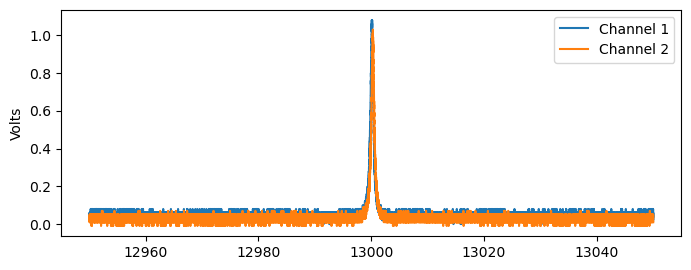

In [174]:
t_raw = data["TIME"].to_numpy()*1e6
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH3"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)

plt.ylabel("Volts")
plt.legend()

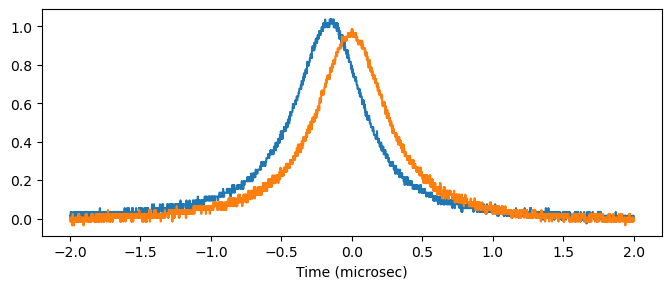

In [175]:
near = np.abs(t_raw - t_raw[np.argmax(ch2_raw)])
select = near < 2
antiselect = near > 3

t = t_raw[select]
t -= np.mean(t)

ch1 = ch1_raw[select] - np.mean(ch1_raw[antiselect])
ch2 = ch2_raw[select] - np.mean(ch1_raw[antiselect])
plt.plot(t, ch1)
plt.plot(t, ch2)Skip to main panel
>
/capstone/lorentzian/
Name
Last Modified

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv
Reading
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150
row_start = 14
metadata = dict()
filename = "lorentzian/T0000ALL.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.5',
 'Label': ''}

data = pd.read_csv(filename, delimiter=",", header=row_start)
data
	TIME 	CH1 	CH3
0 	0.01295 	0.06 	0.05
1 	0.01295 	0.04 	0.05
2 	0.01295 	0.04 	0.03
3 	0.01295 	0.04 	0.05
4 	0.01295 	0.06 	0.03
... 	... 	... 	...
99995 	0.01305 	0.04 	0.05
99996 	0.01305 	0.04 	0.05
99997 	0.01305 	0.04 	0.03
99998 	0.01305 	0.06 	0.03
99999 	0.01305 	0.06 	0.05

100000 rows × 3 columns
t_raw = data["TIME"].to_numpy()
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH3"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 1"
)

plt.ylabel("Volts")
plt.legend()

<matplotlib.legend.Legend at 0x7a59b81ab220>

t = t_raw[ch1_raw>0.1]*1e6
t -= np.mean(t)

ch1 = ch1_raw[ch1_raw>0.1]
ch2 = ch2_raw[ch1_raw>0.1]
plt.scatter(t, ch1, s=1)
plt.scatter(t, ch2, s=1)
plt.xlabel("Time (microsec)")
plt.show()
Selection deleted
curve = lambda t, A, gamma: A / (1 + (t/gamma)**2)

double = lambda t, A, gamma, x0, d, a: a*curve(t-x0, A, gamma) + (1-a)*curve(t-x0-2*d, A, gamma)
delayed = lambda t, A, gamma, x0, d: curve(t-x0-d, A, gamma)

Selection deleted

[[A1, gamma1, x01, d1, a1], cov1] = sp.optimize.curve_fit(double, t, ch1, p0=[2, 1e-5, 0.2, 0.05, 0.5])

[[A2, gamma2, x02, d2], cov2] = sp.optimize.curve_fit(delayed, t, ch2, p0=[2, 1e-5, 0.2, 0.05])


plt.plot(t, ch1)
plt.plot(t, ch2)
plt.plot(t, double(t, A1, gamma1, x01, d1, a1), color="black")
plt.plot(t, delayed(t, A2, gamma2, x02, d2), color="yellow")

(gamma1, gamma2), (d1, d2), (x01, x02), a1

((0.31739052163931575, 0.2985975515628573),
 (-0.15036467147591098, 24.347729771766787),
 (0.1657922706302623, -24.339854896746196),
plt.xlabel("Time (microsec)")
plt.show()

In [176]:
curve = lambda t, A, g: A / (1 + (t/g)**2)

double = lambda t, A, g, h, x, y: curve(t-x, A, g) + curve(t-y, A, h)
delayed = lambda t, A, g, x: curve(t-x, A, g)

((1.0314802610669105, 0.9770861879624073),
 (0.2783642925570313, 0.274756587415639),
 (-0.16256453525889483, -0.00430088624893046))

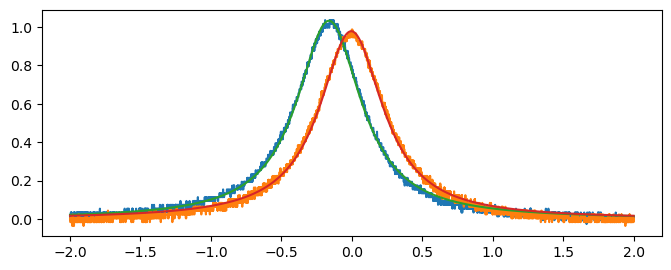

In [177]:
[[A1, g1, x1], cov1] = sp.optimize.curve_fit(delayed, t, ch1, p0=[2, 0.3, 0])
[[A2, g2, x2], cov2] = sp.optimize.curve_fit(delayed, t, ch2, p0=[2, 0.3, 0])


plt.plot(t, ch1)
plt.plot(t, ch2)
plt.plot(t, delayed(t, A1, g1, x1))
plt.plot(t, delayed(t, A2, g2, x2))

(A1, A2),(g1, g2), (x1, x2)

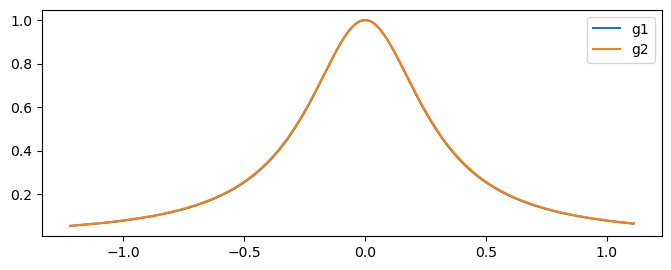

In [162]:
plt.plot(t, curve(t, 1, g1), label="g1")
plt.plot(t, curve(t, 1, g2), label="g2")
plt.legend()

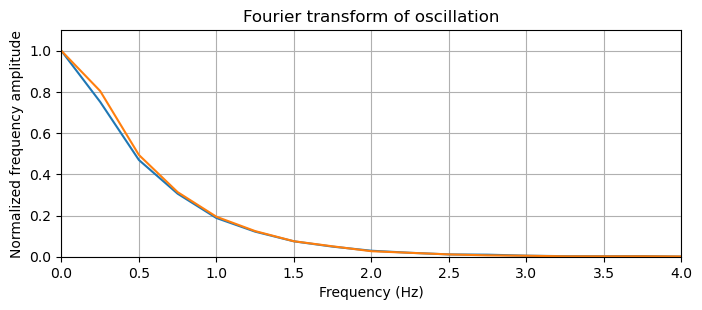

In [188]:
from scipy.fft import fft, fftfreq, fftshift

for ch in [ch1, ch2]:
    spectrum = np.abs(fftshift(fft(ch)))
    spectrum /= np.max(spectrum)
    sampling_rate = 1 / np.average(np.diff(t))
    freq = fftshift(fftfreq(t.size, 1/sampling_rate))
    bin_width = np.average(np.diff(freq))
    plt.plot(freq, spectrum)

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized frequency amplitude")
plt.xlim(0, 4)
plt.ylim(0, 1.1)
plt.grid()
plt.show()